### Supervised ML 
### Dataset https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease#
The dataset: has 25 features including the label feature

In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### Data analysis and Feature evaluation

In [54]:
# read the file 
#if directly using the loadarff -> gave me an error -> here is the workaround



data = []
with open('chronic_kidney_disease_full.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        line = line.replace('\t', '')
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class', 'no_name']
    
df = pd.DataFrame(data[145:], columns=names)

In [55]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,no_name
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,7800,5.2,yes,yes,no,good,no,no,ckd,None
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,6000,?,no,no,no,good,no,no,ckd,None
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,7500,?,no,yes,no,poor,no,yes,ckd,None
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,6700,3.9,yes,no,no,poor,yes,yes,ckd,None
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,7300,4.6,no,no,no,good,no,no,ckd,None


In [56]:
df.shape

(402, 26)

In [57]:
df['class'].value_counts(dropna=False)

ckd       250
notckd    149
NaN         2
no          1
Name: class, dtype: int64

In [58]:
df.no_name.value_counts(dropna=False)

NaN       399
            2
notckd      1
Name: no_name, dtype: int64

In [59]:
df.loc[df['no_name']=='notckd']['class']   #.value_counts()#unique()

369    no
Name: class, dtype: object

In [60]:
df.loc[df['no_name']== ""]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,no_name
69,26,70,1.015,0,4,?,normal,notpresent,notpresent,250,...,6900,6.0,no,yes,no,good,no,no,ckd,
72,64,90,1.010,3,3,?,abnormal,present,notpresent,?,...,?,?,yes,yes,no,good,yes,no,ckd,


In [61]:
df.loc[df['class'] == 'no', 'class'] = df.loc[df['class'] == 'no', 'no_name'].values

In [62]:
df['class'].value_counts(dropna=False)

ckd       250
notckd    150
NaN         2
Name: class, dtype: int64

In [63]:
df = df.dropna(subset = ['class'])

In [64]:
# unbalanced dataset -> 
# lets run without unbalancing -> and if the f1-score is low -> than SMote oversampling technique 

In [65]:
# lets find how many na
df = df.replace(['?', ''], np.nan)

In [66]:
# changing the dtype
column = ['age','bp','sg','al','su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc',]
for i in column:
    df[i] =df[i].astype(float)
    

In [67]:
df.isna().sum()

age          9
bp          12
sg          47
al          46
su          49
rbc        152
pc          65
pcc          4
ba           4
bgr         44
bu          19
sc          17
sod         87
pot         88
hemo        52
pcv         71
wbcc       106
rbcc       131
htn          2
dm           3
cad          2
appet        1
pe           1
ane          1
class        0
no_name    399
dtype: int64

In [68]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [69]:
import seaborn as sns


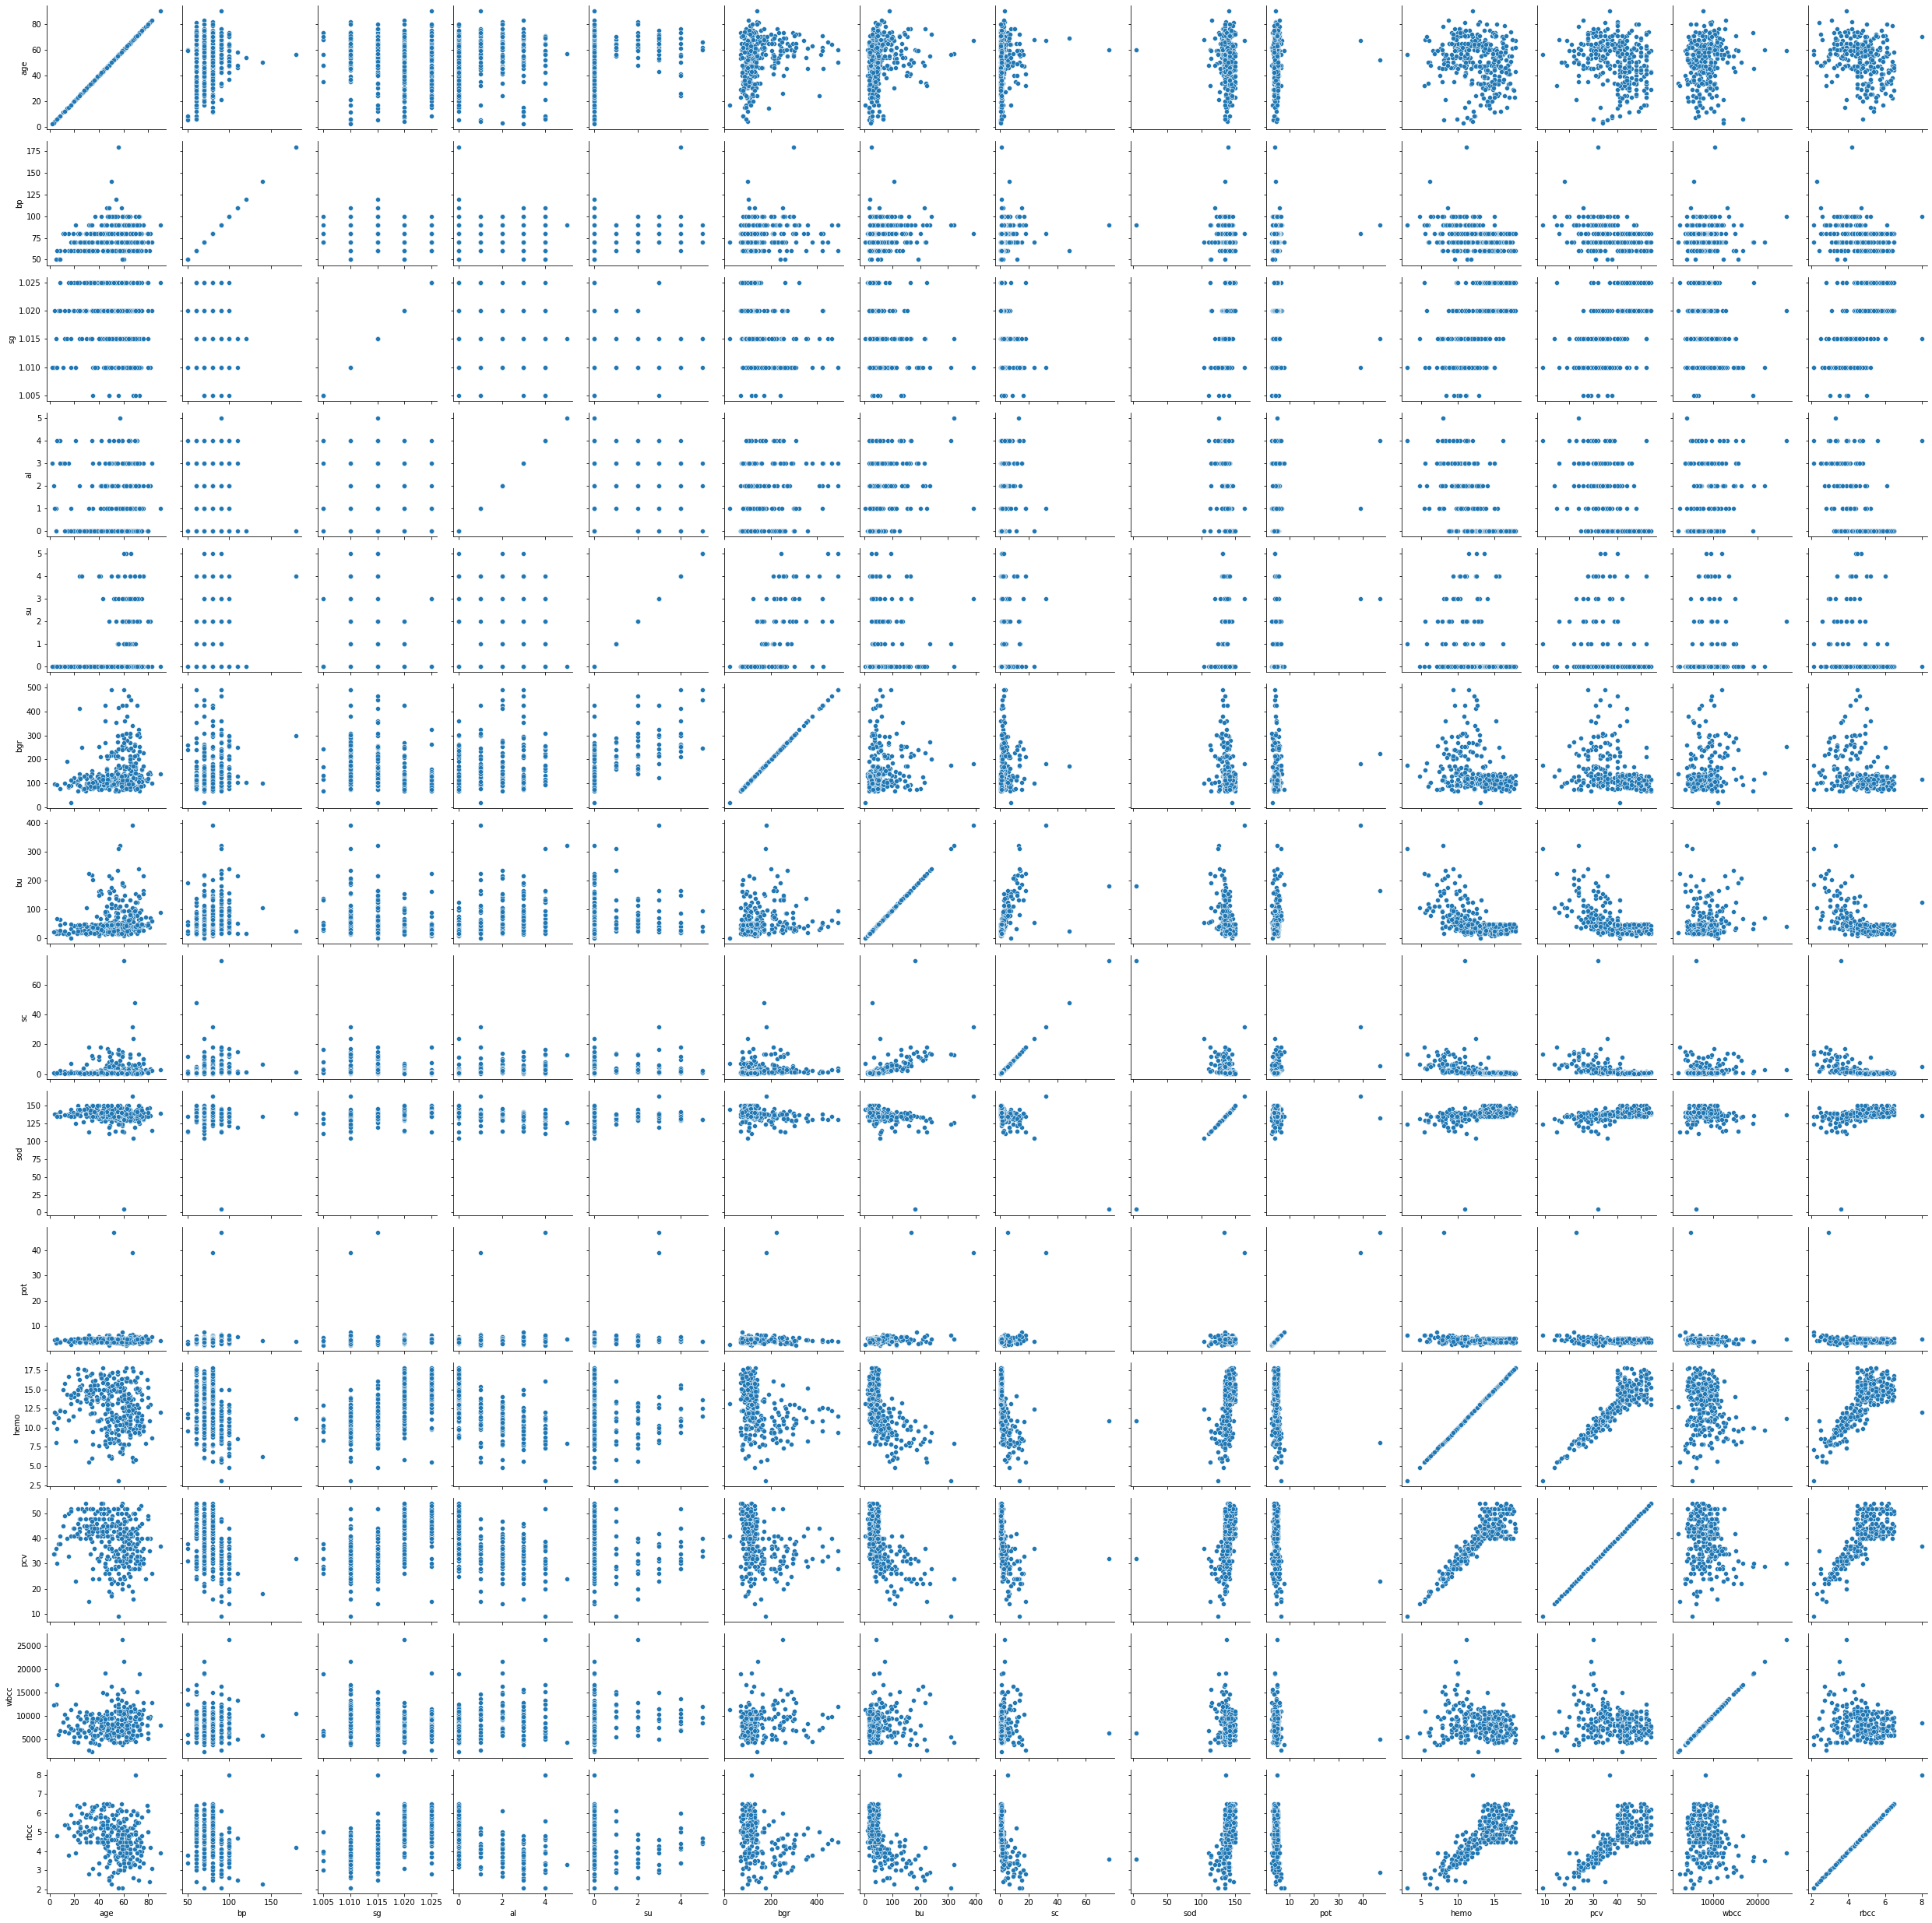

In [70]:
g = sns.PairGrid(df)
g.map(sns.scatterplot)

#. you can see some relationship between the features, the majority between are logic due to the 
#condition such as sc (serum creatinin) and bu (blood urea) or hemo(hemoglobin) and rbc


In [71]:
df = df.drop('no_name', axis = 1)

In [75]:
df.replace({'ckd': 1, 'notckd': 0}, inplace =True)


In [76]:
df['class'].unique()

array([1, 0])

In [77]:
### lets use SVM 


In [78]:
X = df.drop(['class'], axis = 1)
y = df['class'].values

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [80]:
# define the features 
numeric_features = X_train.select_dtypes(include=[float]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()

In [81]:
# imputing by most frequent and one hot encode categorical values 
categorical_transformer = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'most_frequent',
          fill_value = np.nan)),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)


# transformer for numerical features
numeric_transformer = Pipeline(
    [
        ('imputer_num', SimpleImputer(strategy = 'mean')),
        ('scaler', StandardScaler())
    ]
)

# combain in one preprocessor 
preprocessor = ColumnTransformer(
    [
        ('categoricals', categorical_transformer, 
          categorical_features),
        ('numericals', numeric_transformer, numeric_features)
    ],
    remainder = 'drop'
)
# building a pipeline 
pipeline = Pipeline(
    [
        ('preprocessing', preprocessor),
        ('svm', SVC())
    ]
)

In [82]:
model = pipeline.fit(X_train, y_train)

In [83]:
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categoricals',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['rbc', 'pc', 'pcc', 'ba',
                                                   'htn', 'dm', 'cad', 'appet',
                                                   'pe', 'ane']),
                                                 ('numericals',
                                                  Pipeline(steps=[('imputer_num',
                                                        

In [84]:

y_pred=model.predict(X_test)

In [109]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[ 0  0]
 [28 52]]


In [86]:
from sklearn.metrics import f1_score
print(f1_score(y_test,y_pred))

1.0


In [88]:
accuracy_score(y_test, y_pred)

1.0

In [108]:
print(classification_report(y_test, y_pred, zero_division = True))
# no good, for 0 class 

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.65      0.79        80

    accuracy                           0.65        80
   macro avg       0.50      0.82      0.39        80
weighted avg       1.00      0.65      0.79        80



In [112]:
# we have to Apply the oversampling for the class 0 -> SMOTE 

pipeline2 = Pipeline(
    [
        ('preprocessing', preprocessor),
      
    ]
)

from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X_processed = pipeline2.fit_transform(X)

X2, y2 = oversample.fit_resample(X_processed, y)


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.20, random_state=42, shuffle=True)

In [117]:
model = SVC()
model.fit(X_train,y_train)
y_pr = model.predict(X_test)
print(confusion_matrix(y_test, y_pr))

[[54  0]
 [ 0 46]]


In [119]:
print(classification_report(y_test, y_pr))
# much better 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        46

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [120]:
print(f1_score(y_test, y_pr))

1.0
